# Error analysis

This notebook contains some analysis of the wind measurements from SMHI in 2018. The main focus is on outliers in the data. Start by importing relevant packages:

In [1]:
# We want to work with modules from parent directory
import sys
sys.path.append('../')
# Some of the data loading functions produce warnings,
# Let's supress them for neatness sake.
import warnings
warnings.filterwarnings("ignore")

from IPython.core.display import display, HTML
# Decrease the size of the scroll window, the information is not relevant.
display(HTML("<style>div.output_scroll { height: 5em; }</style>"))

# Error analysis
from error_estimation.windfield_prediction import do_random_predictions, do_many_predictions, get_mean_square_error
from error_estimation.time_compression_scoring import trim_data, plot_compression_error, get_compression_error
from emastr_analysis.mean_wind_predictions import prepare_data, plot_mean_wind_error, get_theory_estimates
from emastr_analysis.error_analysis_plots import plot_error_uncertainty, clt_plot
# Time compression functions
from time_compression.time_compression import date_time_to_datetime, TimeCompression
from time_compression.time_lookup_windfield import TimeLookupWindfield
# Models
from models.random_forest_any_degree import RandomForestField
from models.quadratic_fourier_windfield import FourierWindfield
from models.averaging_windfield import AveragingWindfield
# Tools
import framework.data_loader as dl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Let's first make some predictions to work with. We'll use the averaging and random forest models for this purpose.

In [2]:
# Make random forest windfield, load just an hour's worth of data for making the lookup
lookup_data = dl.load_parquet("https://www.tangel.se/wind/wind_frames/wind-20180101-1200.parquet")
rf_wf = RandomForestField.make_random_forest_field(lookup_data, n_trees = 100, poly_degree = 3)

# Make averaging windfield
avg_wf = AveragingWindfield()

# Feel free to experiment with more models here!
fields = [rf_wf, avg_wf]
names = ["Random forest", "Averaging"]

# Load some data to make predictions on (this is a lot of data and might take time)
data = dl.load_parquet("https://www.tangel.se/wind/wind_frames/wind-2018.parquet")

Here we make the actual predictions (might take a while, check the print out for a rough estimation).

In [5]:
# Make predictions from randomly sampled times
# Reduce the number of samples to make the code run faster!
n_samples = 200
prediction_frames = []

for wf in fields:
    prediction_frames.append(do_random_predictions(wf, data, n_samples = n_samples, n_splits = 5, seed = 100))

Predicting time: 2018-01-30 21:00:00
Predicting time: 2018-11-01 17:00:00
Predicting time: 2018-10-28 19:00:00
Predicting time: 2018-02-24 23:00:00
Predicting time: 2018-09-05 05:00:00
Predicting time: 2018-07-30 00:00:00
Predicting time: 2018-10-10 03:00:00
Predicting time: 2018-12-12 16:00:00
Predicting time: 2018-12-28 15:00:00
Predicting time: 2018-04-19 08:00:00
Predicting time: 2018-01-09 22:00:00
Predicting time: 2018-09-21 12:00:00
Predicting time: 2018-10-29 16:00:00
Predicting time: 2018-05-16 01:00:00
Predicting time: 2018-06-07 12:00:00
Predicting time: 2018-03-22 19:00:00
Predicting time: 2018-07-17 11:00:00
Predicting time: 2018-04-16 13:00:00
Predicting time: 2018-06-25 01:00:00
Predicting time: 2018-03-22 03:00:00
Predicting time: 2018-02-28 02:00:00
Predicting time: 2018-01-26 19:00:00
Predicting time: 2018-03-08 23:00:00
Predicting time: 2018-07-27 16:00:00
Predicting time: 2018-08-16 13:00:00
Predicting time: 2018-09-19 17:00:00
Predicting time: 2018-03-28 14:00:00
P

Predicting time: 2018-03-08 23:00:00
Predicting time: 2018-07-27 16:00:00
Predicting time: 2018-08-16 13:00:00
Predicting time: 2018-09-19 17:00:00
Predicting time: 2018-03-28 14:00:00
Predicting time: 2018-09-13 23:00:00
Predicting time: 2018-11-03 00:00:00
Predicting time: 2018-05-26 22:00:00
Predicting time: 2018-08-20 21:00:00
Predicting time: 2018-02-12 14:00:00
Predicting time: 2018-01-12 07:00:00
Predicting time: 2018-03-02 00:00:00
Predicting time: 2018-01-19 12:00:00
Predicting time: 2018-09-07 11:00:00
Predicting time: 2018-02-01 13:00:00
Predicting time: 2018-02-14 10:00:00
Predicting time: 2018-03-12 11:00:00
Predicting time: 2018-02-18 05:00:00
Predicting time: 2018-03-28 06:00:00
Predicting time: 2018-04-23 13:00:00
Predicting time: 2018-10-22 23:00:00
Predicting time: 2018-08-31 16:00:00
Predicting time: 2018-01-14 11:00:00
Predicting time: 2018-06-22 12:00:00
Predicting time: 2018-05-02 01:00:00
Predicting time: 2018-12-12 21:00:00
Predicting time: 2018-06-08 03:00:00
P

### Error uncertainty
In order to estimate the uncertainty of the error approximations, calculate the mean square error for each hour and approximate the variance with bootstrapping methods. For this, either use the function `do_many_bootstraps()`, or the function `plot_error_uncertainty()` in `error_analysis_plots.py`, which both plots the error convergence and prints out the best estimate. The inputs are
* `errors`, a data frame with errors from different models along each column. Each column has to have the same length.
* `n_sample_vec` a vector of values corresponding to `n_sample_vec`in `do_many_bootstraps()`.

Random forest error: 0.363470 +- 0.013453
Averaging error: 0.382655 +- 0.013306


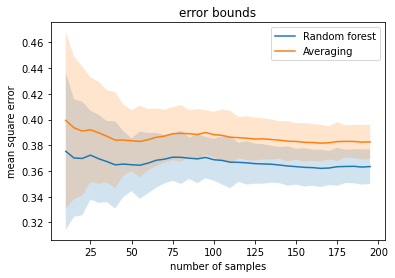

In [5]:
# Calculate the error at each hour.
# Normalize by the mean square speed.
zero_error = (prediction_frames[0].u**2+prediction_frames[0].v**2).mean()
errors = pd.DataFrame()
for frame, name in zip(prediction_frames, names):
    errors[name] = frame.groupby('datetime').apply(get_mean_square_error)/zero_error

# Estimate the variance with error margins with n = 10, 20, 30, ... , 90 samples.
n_vec = [n for n in range(10, n_samples, 5)] 
plot_error_uncertainty(errors, n_vec)

A natural follow-up question is how well the bootstrapped error bounds agree with the central limit theorem. To check this, use the function `clt_plot()` from `error_analysis_plots.py`.

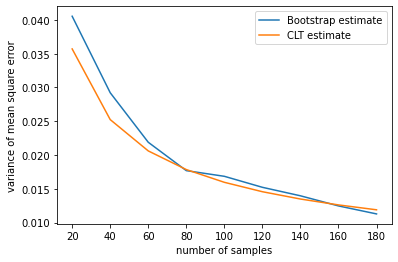

In [6]:
clt_plot(errors["Random forest"], n_max = n_samples)


### Wind data characteristics

Another point of interest is the occurence of outliers and other error sources in the data, which when filtered out can improve the results. We will examine a number of different hypotheses using the functions at hand. First off, let's examine how the prediction errors depend on the velocity.

* The error scales disproportionately with wind speed
* The error scales with altitude 
* The wind models are worse at extrapolation than interpolation
* The error scales with the distance between stations
* The measurement error inherent in the data is high
* Other outliers such as storms are present in the data

First, let's look at the mean square error over time.

Text(0, 0.5, '1-R^2')

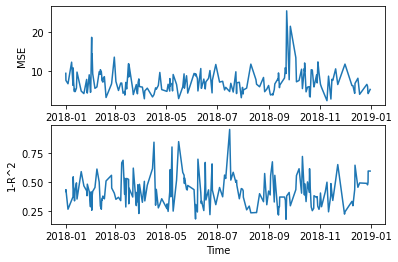

In [7]:
# Select one of the models
frame = prediction_frames[0]

# Group the predictions by time and get the error
zero_error_series = frame.groupby('datetime').apply(lambda f: (f.u**2+f.v**2).mean())
times = zero_error_series.index
zero_error = zero_error_series.values

rf_error = frame.groupby('datetime').apply(get_mean_square_error).values

# Plot error over time
plt.subplot(2,1,1)
plt.plot(times, rf_error)
plt.xlabel('Time')
plt.ylabel('MSE')

plt.subplot(2,1,2)
plt.plot(times, rf_error/zero_error)
plt.xlabel('Time')
plt.ylabel('1-R^2')

Interestingly, the mean square error contains an obvious outlier around september. This might be explained by the storm named *Knud* which passed by the Norwegian coast in mid-to late september 2018 and might be good to exclude when evaluating the model. This outlier dissappears when normalizing. Naturally, this leads to the hypothesis that the models perform proportionately better for high wind speeds. This hypothesis can examined by a simple scatter plot:

Text(0, 0.5, '1-R^2')

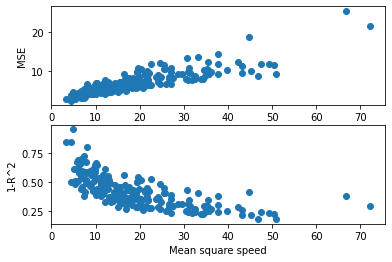

In [8]:
# Plot results
plt.subplot(2,1,1)
plt.scatter(zero_error, rf_error)
plt.xlabel('Mean square speed')
plt.ylabel('MSE')

plt.subplot(2,1,2)
plt.scatter(zero_error, rf_error/zero_error)
plt.xlabel('Mean square speed')
plt.ylabel('1-R^2')

There is a clear positive correlation between the MSE error and the MSS (Mean square speed). This is expected behavior for linear wind models, in which case rescaling all the measurements and then predicting is equivalent to rescaling the predictions. However, there is a negative correlation between the $1-R^2$ and the square wind speed, suggesting that the models perform disproportionately poorly for low windspeeds. Next, let's instead examine the error as a function of altitude:

Text(0, 0.5, 'R^2 error')

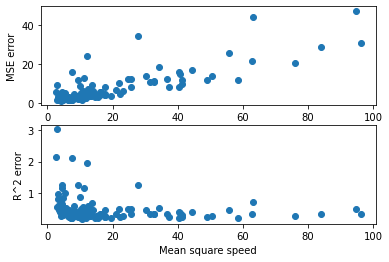

In [9]:
# Group the predictions by time and get the error
zero_error = frame.groupby('altitude').apply(lambda f: (f.u**2+f.v**2).mean()).values
rf_error = frame.groupby('altitude').apply(get_mean_square_error).values

# Plot results
plt.figure()
plt.subplot(2,1,1)
plt.scatter(zero_error, rf_error)
plt.xlabel('Mean square speed')
plt.ylabel('MSE error')

plt.subplot(2,1,2)
plt.scatter(zero_error, rf_error/zero_error)
plt.xlabel('Mean square speed')
plt.ylabel('R^2 error')

The MSE error clearly correlates positively with the altitude, but when normalizing, the correlation disappears. 

## Mean wind predictions
One method of decreasing the prediction error is to aggregate data from consecutive measurements by first fitting a windfield model to each measurement and then taking the mean. The result is a model predicting the mean wind velocity over the chosen time span. First, some notation. Let $u_{m,n}, v_{m,n}$ denote the measured velocity at station $m$ and time $n$.Furthermore, let $u_{m,n}^p, v_{m,n}^p$ be the respective velocity predictions. For simplicity, assume there is no missing data. The mean square error when averaging the velocities over $N$ consecutive times and $M$ stations is expressed as

$$
 \frac{1}{M}\sum_{m=1}^M\left[\left(\frac{1}{N}\sum_{n = 1}^{N} u_{m,n}-u_{m,n}^p \right)^2 + \left(\frac{1}{N}\sum_{j = 1}^{N} v_{m,n}-v_{m,n}^p \right)^2\right]
$$

Denote $e_{m,n}^u = u_{m,n}-u_{m,n}^p$ and $e_{m,n}^v = v_{m,n}-v_{m,n}^p$ and suppose $E_n[e_{m,n}^u]=E_n[e_{m,n}^v]=0$. Define the expected value of the above expression, the "mean square error of the $N-$velocity means" or "$N-$velocity mean MSE:

$$ 
    \frac{1}{N^2M}\sum_{m=1}^M\left(\mathrm{Var}\left[\sum_{n=1}^N e_{m,n}^u\right]+\mathrm{Var}\left[\sum_{n=1}^N e_{m,n}^v\right]\right)
$$

This expectation can be estimated with a monte carlo estimate by sampling from the available times in the data, but we can also make some rough estimations to compare with. If the prediction errors for a given station are uncorrelated in time with variance $\sigma^u_m,\sigma^v_m$, the formula above can be simplified to the *IID* approximation

$$
    IID = \frac{1}{NM}\sum_{m=1}(\sigma_m^u)^2 + \frac{1}{NM}\sum_{m=1}(\sigma_m^v)^2 = \frac{\sigma_u^2+\sigma_v^2}{N}
$$
where we define $\sigma_u$ and $\sigma_v$ as the average of $\sigma^u_m,\sigma^v_m$ over the stations. In actuality, the errors are clearly correlated, so let's take this into consideration by instead assuming that the errors evolve as a stationary zero-mean AR(1) process: $e_{n+1} = \phi e_{n} + z_{n+1}$ where $|\phi|<1$ is a constant and $z_{n}$ is white noise. In this case, the variance of a sample mean follows the expression

$$
    \mathrm{Var}\left[\frac{1}{N}\sum_{n=1}^N e_{n}\right] =  \mathrm{Var}[e_n]\frac{N(1-\phi^2) - 2\phi(\phi^N -1)}{N^2(1-\phi)^2}
$$

And so the sought *AR(1)* estimation for the $N$ - velocity mean MSE is

$$
\mathrm{AR1} = \frac{1}{M}\sum_{m=1}^M(\sigma_m^u)^2\frac{N(1-(\phi^u_m)^2) - 2\phi_m^u((\phi^u_m)^N -1)}{N^2(1-\phi_m^u)^2} + \frac{1}{M}\sum_{m=1}^M(\sigma_m^v)^2\frac{N(1-(\phi^v_m)^2) - 2\phi_m^v((\phi^v_m)^N -1)}{N^2(1-\phi_m^v)^2}
$$

It is easily verified that the AR1 estimation is consistent with the IID estimation in the case $\phi=0$, which is expected. Hence, the AR1 has more predictive power than the IID model. If the AR1 model proves to fit the $N-$velocity mean MSE for some set of $N$, it can arguably be used to infer results for larger values of N than have been calculated. For example, it could be used to estimate the $N-$velocity mean MSE over an entire year without having to generate multiple one-year velocity mean predictions and then look at the variance. To evaluate the accuracy of the AR(1) model, use the code found in `mean_wind_predictions.py`. There are a number of functions in play here that allow the user to do the computation heavy tasks first and save the data. For the sake of brevity, we'll just use `plot_mean_wind_error()`, which does that for us. The inputs for the functions are

* `pr`, a data frame consisting of predictions from a large number of consecutive times. This data can be created using  the function `do_many_predictions()` from the file `windfield_prediction.py`. 
* `ns`, an array containing the values of N for which to estimate the variance of the mean wind error.
* `bootstraps`, the number of samples 

Begin by creating the predictions needed (let's use the averaging windfield model):

In [9]:
# Remove times with too few measurements
data = prepare_data(data)
# Pick the first 1000 times to make predictions.
times = np.sort(data.datetime.unique())[0:1000]
# Create predictions.
pr = do_many_predictions(avg_wf, data, times, n_splits = 5, verbose = True)

Making predictions at datetime:  01-Jan-2018 (05:00:00)
0.1 % done, elapsed time: 0.418, time remaining: 0:06:58
Making predictions at datetime:  01-Jan-2018 (07:00:00)
0.2 % done, elapsed time: 0.842, time remaining: 0:07:00
Making predictions at datetime:  01-Jan-2018 (08:00:00)
0.3 % done, elapsed time: 1.33, time remaining: 0:07:22
Making predictions at datetime:  01-Jan-2018 (09:00:00)
0.4 % done, elapsed time: 1.88, time remaining: 0:07:49
Making predictions at datetime:  01-Jan-2018 (17:00:00)
0.5 % done, elapsed time: 2.33, time remaining: 0:07:44
Making predictions at datetime:  01-Jan-2018 (18:00:00)
0.6 % done, elapsed time: 2.76, time remaining: 0:07:37
Making predictions at datetime:  01-Jan-2018 (19:00:00)
0.7 % done, elapsed time: 3.18, time remaining: 0:07:32
Making predictions at datetime:  01-Jan-2018 (20:00:00)
0.8 % done, elapsed time: 3.61, time remaining: 0:07:27
Making predictions at datetime:  01-Jan-2018 (21:00:00)
0.9 % done, elapsed time: 4.04, time remaining

Making predictions at datetime:  18-Jan-2018 (14:00:00)
7.5 % done, elapsed time: 32.7, time remaining: 0:06:44
Making predictions at datetime:  18-Jan-2018 (15:00:00)
7.6 % done, elapsed time: 33.1, time remaining: 0:06:43
Making predictions at datetime:  18-Jan-2018 (16:00:00)
7.7 % done, elapsed time: 33.6, time remaining: 0:06:42
Making predictions at datetime:  18-Jan-2018 (17:00:00)
7.8 % done, elapsed time: 34.0, time remaining: 0:06:42
Making predictions at datetime:  18-Jan-2018 (18:00:00)
7.9 % done, elapsed time: 34.4, time remaining: 0:06:42
Making predictions at datetime:  18-Jan-2018 (19:00:00)
8.0 % done, elapsed time: 34.9, time remaining: 0:06:41
Making predictions at datetime:  18-Jan-2018 (20:00:00)
8.1 % done, elapsed time: 35.3, time remaining: 0:06:41
Making predictions at datetime:  18-Jan-2018 (21:00:00)
8.2 % done, elapsed time: 35.8, time remaining: 0:06:40
Making predictions at datetime:  18-Jan-2018 (22:00:00)
8.3 % done, elapsed time: 36.2, time remaining: 

Making predictions at datetime:  25-Jan-2018 (15:00:00)
14.8 % done, elapsed time: 64.0, time remaining: 0:06:09
Making predictions at datetime:  25-Jan-2018 (16:00:00)
14.9 % done, elapsed time: 64.5, time remaining: 0:06:08
Making predictions at datetime:  25-Jan-2018 (17:00:00)
15.0 % done, elapsed time: 64.9, time remaining: 0:06:08
Making predictions at datetime:  25-Jan-2018 (18:00:00)
15.1 % done, elapsed time: 65.3, time remaining: 0:06:07
Making predictions at datetime:  25-Jan-2018 (19:00:00)
15.2 % done, elapsed time: 65.7, time remaining: 0:06:07
Making predictions at datetime:  25-Jan-2018 (20:00:00)
15.3 % done, elapsed time: 66.2, time remaining: 0:06:06
Making predictions at datetime:  25-Jan-2018 (21:00:00)
15.4 % done, elapsed time: 66.6, time remaining: 0:06:06
Making predictions at datetime:  25-Jan-2018 (22:00:00)
15.5 % done, elapsed time: 67.0, time remaining: 0:06:05
Making predictions at datetime:  25-Jan-2018 (23:00:00)
15.6 % done, elapsed time: 67.4, time re

Making predictions at datetime:  31-Jan-2018 (05:00:00)
22.1 % done, elapsed time: 95.3, time remaining: 0:05:36
Making predictions at datetime:  31-Jan-2018 (06:00:00)
22.2 % done, elapsed time: 95.7, time remaining: 0:05:36
Making predictions at datetime:  31-Jan-2018 (07:00:00)
22.3 % done, elapsed time: 96.2, time remaining: 0:05:35
Making predictions at datetime:  31-Jan-2018 (08:00:00)
22.4 % done, elapsed time: 96.6, time remaining: 0:05:35
Making predictions at datetime:  31-Jan-2018 (10:00:00)
22.5 % done, elapsed time: 97.0, time remaining: 0:05:34
Making predictions at datetime:  31-Jan-2018 (11:00:00)
22.6 % done, elapsed time: 97.5, time remaining: 0:05:34
Making predictions at datetime:  31-Jan-2018 (12:00:00)
22.7 % done, elapsed time: 97.9, time remaining: 0:05:33
Making predictions at datetime:  31-Jan-2018 (13:00:00)
22.8 % done, elapsed time: 98.3, time remaining: 0:05:33
Making predictions at datetime:  31-Jan-2018 (14:00:00)
22.9 % done, elapsed time: 98.7, time re

Making predictions at datetime:  12-Feb-2018 (16:00:00)
29.2 % done, elapsed time: 1.26e+02, time remaining: 0:05:05
Making predictions at datetime:  12-Feb-2018 (17:00:00)
29.3 % done, elapsed time: 1.26e+02, time remaining: 0:05:05
Making predictions at datetime:  12-Feb-2018 (18:00:00)
29.4 % done, elapsed time: 1.27e+02, time remaining: 0:05:04
Making predictions at datetime:  12-Feb-2018 (21:00:00)
29.5 % done, elapsed time: 1.27e+02, time remaining: 0:05:04
Making predictions at datetime:  12-Feb-2018 (22:00:00)
29.6 % done, elapsed time: 1.28e+02, time remaining: 0:05:04
Making predictions at datetime:  12-Feb-2018 (23:00:00)
29.7 % done, elapsed time: 1.28e+02, time remaining: 0:05:03
Making predictions at datetime:  13-Feb-2018 (08:00:00)
29.8 % done, elapsed time: 1.29e+02, time remaining: 0:05:03
Making predictions at datetime:  13-Feb-2018 (10:00:00)
29.9 % done, elapsed time: 1.29e+02, time remaining: 0:05:03
Making predictions at datetime:  13-Feb-2018 (13:00:00)
30.0 % d

Making predictions at datetime:  17-Feb-2018 (15:00:00)
36.3 % done, elapsed time: 1.56e+02, time remaining: 0:04:35
Making predictions at datetime:  17-Feb-2018 (16:00:00)
36.4 % done, elapsed time: 1.57e+02, time remaining: 0:04:34
Making predictions at datetime:  17-Feb-2018 (17:00:00)
36.5 % done, elapsed time: 1.57e+02, time remaining: 0:04:34
Making predictions at datetime:  17-Feb-2018 (18:00:00)
36.6 % done, elapsed time: 1.58e+02, time remaining: 0:04:33
Making predictions at datetime:  17-Feb-2018 (19:00:00)
36.7 % done, elapsed time: 1.58e+02, time remaining: 0:04:33
Making predictions at datetime:  17-Feb-2018 (21:00:00)
36.8 % done, elapsed time: 1.59e+02, time remaining: 0:04:32
Making predictions at datetime:  17-Feb-2018 (22:00:00)
36.9 % done, elapsed time: 1.59e+02, time remaining: 0:04:32
Making predictions at datetime:  17-Feb-2018 (23:00:00)
37.0 % done, elapsed time: 1.6e+02, time remaining: 0:04:32
Making predictions at datetime:  18-Feb-2018 (00:00:00)
37.1 % do

Making predictions at datetime:  22-Feb-2018 (15:00:00)
43.4 % done, elapsed time: 1.87e+02, time remaining: 0:04:04
Making predictions at datetime:  22-Feb-2018 (16:00:00)
43.5 % done, elapsed time: 1.88e+02, time remaining: 0:04:04
Making predictions at datetime:  22-Feb-2018 (17:00:00)
43.6 % done, elapsed time: 1.88e+02, time remaining: 0:04:04
Making predictions at datetime:  22-Feb-2018 (19:00:00)
43.7 % done, elapsed time: 1.89e+02, time remaining: 0:04:03
Making predictions at datetime:  22-Feb-2018 (20:00:00)
43.8 % done, elapsed time: 1.89e+02, time remaining: 0:04:03
Making predictions at datetime:  22-Feb-2018 (21:00:00)
43.9 % done, elapsed time: 1.9e+02, time remaining: 0:04:02
Making predictions at datetime:  22-Feb-2018 (22:00:00)
44.0 % done, elapsed time: 1.9e+02, time remaining: 0:04:02
Making predictions at datetime:  22-Feb-2018 (23:00:00)
44.1 % done, elapsed time: 1.9e+02, time remaining: 0:04:01
Making predictions at datetime:  23-Feb-2018 (00:00:00)
44.2 % done

Making predictions at datetime:  28-Feb-2018 (16:00:00)
50.5 % done, elapsed time: 2.18e+02, time remaining: 0:03:34
Making predictions at datetime:  28-Feb-2018 (17:00:00)
50.6 % done, elapsed time: 2.18e+02, time remaining: 0:03:33
Making predictions at datetime:  28-Feb-2018 (18:00:00)
50.7 % done, elapsed time: 2.19e+02, time remaining: 0:03:33
Making predictions at datetime:  28-Feb-2018 (19:00:00)
50.8 % done, elapsed time: 2.19e+02, time remaining: 0:03:32
Making predictions at datetime:  28-Feb-2018 (20:00:00)
50.9 % done, elapsed time: 2.2e+02, time remaining: 0:03:32
Making predictions at datetime:  28-Feb-2018 (22:00:00)
51.0 % done, elapsed time: 2.2e+02, time remaining: 0:03:32
Making predictions at datetime:  28-Feb-2018 (23:00:00)
51.1 % done, elapsed time: 2.21e+02, time remaining: 0:03:31
Making predictions at datetime:  01-Mar-2018 (00:00:00)
51.2 % done, elapsed time: 2.21e+02, time remaining: 0:03:31
Making predictions at datetime:  01-Mar-2018 (01:00:00)
51.3 % don

Making predictions at datetime:  04-Mar-2018 (09:00:00)
57.6 % done, elapsed time: 2.48e+02, time remaining: 0:03:03
Making predictions at datetime:  04-Mar-2018 (10:00:00)
57.7 % done, elapsed time: 2.49e+02, time remaining: 0:03:02
Making predictions at datetime:  04-Mar-2018 (11:00:00)
57.8 % done, elapsed time: 2.49e+02, time remaining: 0:03:02
Making predictions at datetime:  04-Mar-2018 (12:00:00)
57.9 % done, elapsed time: 2.5e+02, time remaining: 0:03:02
Making predictions at datetime:  04-Mar-2018 (13:00:00)
58.0 % done, elapsed time: 2.5e+02, time remaining: 0:03:01
Making predictions at datetime:  04-Mar-2018 (14:00:00)
58.1 % done, elapsed time: 2.51e+02, time remaining: 0:03:01
Making predictions at datetime:  04-Mar-2018 (15:00:00)
58.2 % done, elapsed time: 2.51e+02, time remaining: 0:03:00
Making predictions at datetime:  04-Mar-2018 (16:00:00)
58.3 % done, elapsed time: 2.51e+02, time remaining: 0:03:00
Making predictions at datetime:  04-Mar-2018 (17:00:00)
58.4 % don

Making predictions at datetime:  19-Mar-2018 (10:00:00)
64.7 % done, elapsed time: 2.79e+02, time remaining: 0:02:32
Making predictions at datetime:  19-Mar-2018 (11:00:00)
64.8 % done, elapsed time: 2.79e+02, time remaining: 0:02:32
Making predictions at datetime:  19-Mar-2018 (12:00:00)
64.9 % done, elapsed time: 2.8e+02, time remaining: 0:02:31
Making predictions at datetime:  19-Mar-2018 (13:00:00)
65.0 % done, elapsed time: 2.8e+02, time remaining: 0:02:31
Making predictions at datetime:  19-Mar-2018 (14:00:00)
65.1 % done, elapsed time: 2.81e+02, time remaining: 0:02:30
Making predictions at datetime:  19-Mar-2018 (15:00:00)
65.2 % done, elapsed time: 2.81e+02, time remaining: 0:02:30
Making predictions at datetime:  19-Mar-2018 (16:00:00)
65.3 % done, elapsed time: 2.81e+02, time remaining: 0:02:30
Making predictions at datetime:  19-Mar-2018 (17:00:00)
65.4 % done, elapsed time: 2.82e+02, time remaining: 0:02:29
Making predictions at datetime:  19-Mar-2018 (18:00:00)
65.5 % don

Making predictions at datetime:  24-Mar-2018 (02:00:00)
71.8 % done, elapsed time: 3.09e+02, time remaining: 0:02:01
Making predictions at datetime:  24-Mar-2018 (03:00:00)
71.9 % done, elapsed time: 3.1e+02, time remaining: 0:02:01
Making predictions at datetime:  24-Mar-2018 (04:00:00)
72.0 % done, elapsed time: 3.1e+02, time remaining: 0:02:01
Making predictions at datetime:  24-Mar-2018 (05:00:00)
72.1 % done, elapsed time: 3.11e+02, time remaining: 0:02:00
Making predictions at datetime:  24-Mar-2018 (06:00:00)
72.2 % done, elapsed time: 3.11e+02, time remaining: 0:02:00
Making predictions at datetime:  24-Mar-2018 (07:00:00)
72.3 % done, elapsed time: 3.11e+02, time remaining: 0:01:59
Making predictions at datetime:  24-Mar-2018 (08:00:00)
72.4 % done, elapsed time: 3.12e+02, time remaining: 0:01:59
Making predictions at datetime:  24-Mar-2018 (09:00:00)
72.5 % done, elapsed time: 3.12e+02, time remaining: 0:01:58
Making predictions at datetime:  24-Mar-2018 (10:00:00)
72.6 % don

Making predictions at datetime:  27-Mar-2018 (14:00:00)
78.9 % done, elapsed time: 3.45e+02, time remaining: 0:01:32
Making predictions at datetime:  27-Mar-2018 (15:00:00)
79.0 % done, elapsed time: 3.46e+02, time remaining: 0:01:32
Making predictions at datetime:  27-Mar-2018 (16:00:00)
79.1 % done, elapsed time: 3.46e+02, time remaining: 0:01:31
Making predictions at datetime:  27-Mar-2018 (17:00:00)
79.2 % done, elapsed time: 3.47e+02, time remaining: 0:01:31
Making predictions at datetime:  27-Mar-2018 (18:00:00)
79.3 % done, elapsed time: 3.47e+02, time remaining: 0:01:31
Making predictions at datetime:  27-Mar-2018 (20:00:00)
79.4 % done, elapsed time: 3.48e+02, time remaining: 0:01:30
Making predictions at datetime:  27-Mar-2018 (21:00:00)
79.5 % done, elapsed time: 3.48e+02, time remaining: 0:01:30
Making predictions at datetime:  28-Mar-2018 (03:00:00)
79.6 % done, elapsed time: 3.48e+02, time remaining: 0:01:29
Making predictions at datetime:  28-Mar-2018 (04:00:00)
79.7 % d

Making predictions at datetime:  31-Mar-2018 (11:00:00)
86.0 % done, elapsed time: 3.77e+02, time remaining: 0:01:01
Making predictions at datetime:  31-Mar-2018 (12:00:00)
86.1 % done, elapsed time: 3.77e+02, time remaining: 0:01:01
Making predictions at datetime:  31-Mar-2018 (13:00:00)
86.2 % done, elapsed time: 3.78e+02, time remaining: 0:01:00
Making predictions at datetime:  31-Mar-2018 (14:00:00)
86.3 % done, elapsed time: 3.78e+02, time remaining: 0:01:00
Making predictions at datetime:  31-Mar-2018 (15:00:00)
86.4 % done, elapsed time: 3.79e+02, time remaining: 0:01:00
Making predictions at datetime:  31-Mar-2018 (16:00:00)
86.5 % done, elapsed time: 3.79e+02, time remaining: 0:00:59
Making predictions at datetime:  31-Mar-2018 (17:00:00)
86.6 % done, elapsed time: 3.8e+02, time remaining: 0:00:59
Making predictions at datetime:  31-Mar-2018 (18:00:00)
86.7 % done, elapsed time: 3.8e+02, time remaining: 0:00:58
Making predictions at datetime:  31-Mar-2018 (19:00:00)
86.8 % don

Making predictions at datetime:  03-Apr-2018 (19:00:00)
93.1 % done, elapsed time: 4.08e+02, time remaining: 0:00:30
Making predictions at datetime:  03-Apr-2018 (20:00:00)
93.2 % done, elapsed time: 4.09e+02, time remaining: 0:00:30
Making predictions at datetime:  03-Apr-2018 (21:00:00)
93.3 % done, elapsed time: 4.09e+02, time remaining: 0:00:29
Making predictions at datetime:  03-Apr-2018 (22:00:00)
93.4 % done, elapsed time: 4.09e+02, time remaining: 0:00:29
Making predictions at datetime:  03-Apr-2018 (23:00:00)
93.5 % done, elapsed time: 4.1e+02, time remaining: 0:00:28
Making predictions at datetime:  04-Apr-2018 (00:00:00)
93.6 % done, elapsed time: 4.1e+02, time remaining: 0:00:28
Making predictions at datetime:  04-Apr-2018 (01:00:00)
93.7 % done, elapsed time: 4.11e+02, time remaining: 0:00:28
Making predictions at datetime:  04-Apr-2018 (02:00:00)
93.8 % done, elapsed time: 4.11e+02, time remaining: 0:00:27
Making predictions at datetime:  04-Apr-2018 (06:00:00)
93.9 % don

Now, use the predictions to estimate the mean wind prediction error.

Bootstrapping mean with 1 samples and 100 bootstraps
Bootstrapping mean with 6 samples and 100 bootstraps
Bootstrapping mean with 11 samples and 100 bootstraps
Bootstrapping mean with 16 samples and 100 bootstraps
Bootstrapping mean with 21 samples and 100 bootstraps
Bootstrapping mean with 26 samples and 100 bootstraps
Bootstrapping mean with 31 samples and 100 bootstraps
Bootstrapping mean with 36 samples and 100 bootstraps
Supress variable printout


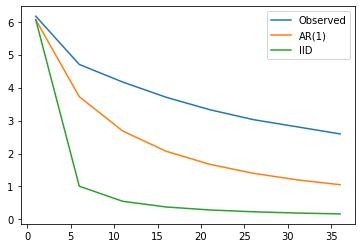

In [10]:
ns = [n for n in range(1, 41, 5)]
plot_mean_wind_error(pr, ns, 100)
print("Supress variable printout")

As shown in the figure, both the IID and AR(1) estimates seem to be smaller than the bootstrapped error variance. In the limit, as the number of bootstraps are increased, the three plots should cross in $n=1$. Using more bootstrap replicas would give us a better idea of how well the AR(1) model fits the data. Feel free to mess around with the parameters. The AR(1) is not a conservative estimate, rather it constitutes a lower bound for the error. Let's say we want to use the AR(1) model to estimate the number of samples needed to get the mean square error to approximately $3.5\;m^2/s^2$. This is as simple as calling the function `get_theory_estimates()`. It takes the arguments

* `pr_ers` a data frame with the prediction errors. We can get them by using the function `add_error_columns()` on a frame of predictions obtained from `do_many_predictions()` or `do_random_predictions()`.
* `ns`an array of the values of N for which to estimate the expected square mean wind prediction error.

The function returns two arrays,

* `AR1_errors`, the AR1 estimates given the specified values of N found in `ns`
* `IID_errors`, the IID estimates given the specified values of N found in `ns`

For example, we can guess a range of possible values for N and then check if the error is sufficiently small.

In [11]:
e_target = 7/400
# Possible candidates
ns = [n for n in range(7000, 9000)]
AR1_error, _ = get_theory_estimates(pr, ns)

idx, = np.where(AR1_error < e_target)

if len(idx) == 0:
    print("Need more terms!")
else:
    print("Need at least {0} terms.".format(ns[idx[0]]))


Need at least 7000 terms.


Since the measurements are taken by the hour, the code tells us that in order to decrease the mean square error by a factor of about 400, we have to use at least an entire year's worth of measurements. The AR(1) model is much faster than simply bootstrapping from the predictions, but seems to be consistently undershooting the real error. Therefore, we might need even more samples.

## Time Compression

The time compression wind field found in `time_compression.py` is a way to decrease the number of wind field fits needed in order predict a large set of data. To be precise, define a vector $\pmb{u}_n = [u_{1,n}, \dots , u_{M,n}]$ consisting of all the velocity measurements for a given time $n$. The set $\{\pmb{u}_n\}_n$ can then be viewed as realizations of a probability distribution in $\mathcal{R}^M$, for which a PCA analysis can be done, to find the principal components $\{\pmb{w}_k\}_{k=1}^M$ with eigenvalues $\sigma_k^2$ in descending order. The time compression algorithm then performs a fit on a subset of the principal components $\{\pmb{w}_k\}_{k=1}^K$ using a given wind model. If the model is linear with respect to the velocity data, the prediction at $x,y$ given measurements $\pmb{u}$ can be written as $M(x,y)\pmb{u}$. Under this assumption, it is possible to approximate the expected square compression loss. Let $\alpha_{k,n}$ be projections of $\pmb{u}_n$ onto the principal components, and let $b_k^2 = \pmb{w}_k^T E[\pmb{u}]^TE[\pmb{u}]\pmb{w}_k$. Then

$$
E\left[\left| M(x,y)\pmb{u} - \sum_{k=1}^K \alpha_{k,n}M(x,y)\pmb{w}_k\right|^2\right] \leq |M(x,y)|^2\sum_{k=K+1}^M (\sigma_k^2 + b_k^2)
$$

Where $|M(x,y)|$ is some matrix norm, for example $\min\limits_{|v|=1} |M(x,y)v|$. An alternative to this theoretical approximation is to try and estimate the compression loss from available data. The function `plot_compression_error()` in `time_compression_scoring.py` does exactly this. The function runs 5-fold cross validation on a trimmed subset of the 2018 wind data from SMHI to generate the mean square error as a function of the number of principal components used. The function takes the arguments

* `windfield_factories`, a list of windfield factories for different models.
* `windfield_names`, a list of labels for each windfield model to use in the plot.
* `data`, the data to run 5-fold cross validation on. It has to be passed through the function `trim_data()` first, to extract a subset of the data with measurements from the same stations.
* `n_components`, a list of different numbers of principal components to plot out the error for.
* `n_samples`, the number of times to randomly sample from the data and use to score the performance.

Let's run this code on the fourier wind field. Start by loading data to train on:

In [12]:
# Load and trim data
n_stations = 120  # Number of stations to keep 
data = dl.load_parquet("https://www.tangel.se/wind/wind_frames/wind-2018.parquet")
data = data[data['date'].apply(lambda f: f[0:7]) != '2018-09']  # Filter out the storm in september
data = date_time_to_datetime(data)
data = trim_data(data, n_stations)

Then, we define windfield factories for both wind fields:

In [13]:
factories = [lambda: FourierWindfield((11,11), 'sobolev', 0.001, 0.01)]
names = ["Fourier 11x11"]

Finally, make a list of the number of principal components to plot the error of. Note, since we are using 5-fold cross validation, the maximal number of components is 4/5 times the number of stations in the data.

In [14]:
n_max = int(4/5*n_stations)
n_components = [n for n in range(1, n_max, 2)] 

Now we are ready to plot the results. This process is very slow if we use to many samples, so let's just use 10. First, get the data with `get_compression_error()`. 

In [15]:
n_samples = 10
compressed, uncompressed = get_compression_error(factories, data, n_components, n_samples)

Fitting to data at time  2018-02-12 16:00:00
Predicting data
Fitting to data at time  2018-02-28 23:00:00
Predicting data
Fitting to data at time  2018-03-14 19:00:00
Predicting data
Fitting to data at time  2018-03-27 15:00:00
Predicting data
Fitting to data at time  2018-04-03 16:00:00
Predicting data
Fitting to data at time  2018-05-11 22:00:00
Predicting data
Fitting to data at time  2018-06-25 11:00:00
Predicting data
Fitting to data at time  2018-07-24 07:00:00
Predicting data
Fitting to data at time  2018-11-12 10:00:00
Predicting data
Fitting to data at time  2018-12-15 04:00:00
Predicting data
Fitting to data at time  2018-02-12 16:00:00
Predicting data
Fitting to data at time  2018-02-28 23:00:00
Predicting data
Fitting to data at time  2018-03-14 19:00:00
Predicting data
Fitting to data at time  2018-03-27 15:00:00
Predicting data
Fitting to data at time  2018-04-03 16:00:00
Predicting data
Fitting to data at time  2018-05-11 22:00:00
Predicting data
Fitting to data at time 

Predicting  2018-11-12 10:00:00
Predicting  2018-12-15 04:00:00
pivoting data
computing pca components
fitting windfields
Predicting  2018-02-12 16:00:00
Predicting  2018-02-28 23:00:00
Predicting  2018-03-14 19:00:00
Predicting  2018-03-27 15:00:00
Predicting  2018-04-03 16:00:00
Predicting  2018-05-11 22:00:00
Predicting  2018-06-25 11:00:00
Predicting  2018-07-24 07:00:00
Predicting  2018-11-12 10:00:00
Predicting  2018-12-15 04:00:00
Calculating error for 7 PCA components
pivoting data
computing pca components
fitting windfields
Predicting  2018-02-12 16:00:00
Predicting  2018-02-28 23:00:00
Predicting  2018-03-14 19:00:00
Predicting  2018-03-27 15:00:00
Predicting  2018-04-03 16:00:00
Predicting  2018-05-11 22:00:00
Predicting  2018-06-25 11:00:00
Predicting  2018-07-24 07:00:00
Predicting  2018-11-12 10:00:00
Predicting  2018-12-15 04:00:00
pivoting data
computing pca components
fitting windfields
Predicting  2018-02-12 16:00:00
Predicting  2018-02-28 23:00:00
Predicting  2018-03

computing pca components
fitting windfields
Predicting  2018-02-12 16:00:00
Predicting  2018-02-28 23:00:00
Predicting  2018-03-14 19:00:00
Predicting  2018-03-27 15:00:00
Predicting  2018-04-03 16:00:00
Predicting  2018-05-11 22:00:00
Predicting  2018-06-25 11:00:00
Predicting  2018-07-24 07:00:00
Predicting  2018-11-12 10:00:00
Predicting  2018-12-15 04:00:00
pivoting data
computing pca components
fitting windfields
Predicting  2018-02-12 16:00:00
Predicting  2018-02-28 23:00:00
Predicting  2018-03-14 19:00:00
Predicting  2018-03-27 15:00:00
Predicting  2018-04-03 16:00:00
Predicting  2018-05-11 22:00:00
Predicting  2018-06-25 11:00:00
Predicting  2018-07-24 07:00:00
Predicting  2018-11-12 10:00:00
Predicting  2018-12-15 04:00:00
pivoting data
computing pca components
fitting windfields
Predicting  2018-02-12 16:00:00
Predicting  2018-02-28 23:00:00
Predicting  2018-03-14 19:00:00
Predicting  2018-03-27 15:00:00
Predicting  2018-04-03 16:00:00
Predicting  2018-05-11 22:00:00
Predicti

Predicting  2018-03-14 19:00:00
Predicting  2018-03-27 15:00:00
Predicting  2018-04-03 16:00:00
Predicting  2018-05-11 22:00:00
Predicting  2018-06-25 11:00:00
Predicting  2018-07-24 07:00:00
Predicting  2018-11-12 10:00:00
Predicting  2018-12-15 04:00:00
pivoting data
computing pca components
fitting windfields
Predicting  2018-02-12 16:00:00
Predicting  2018-02-28 23:00:00
Predicting  2018-03-14 19:00:00
Predicting  2018-03-27 15:00:00
Predicting  2018-04-03 16:00:00
Predicting  2018-05-11 22:00:00
Predicting  2018-06-25 11:00:00
Predicting  2018-07-24 07:00:00
Predicting  2018-11-12 10:00:00
Predicting  2018-12-15 04:00:00
pivoting data
computing pca components
fitting windfields
Predicting  2018-02-12 16:00:00
Predicting  2018-02-28 23:00:00
Predicting  2018-03-14 19:00:00
Predicting  2018-03-27 15:00:00
Predicting  2018-04-03 16:00:00
Predicting  2018-05-11 22:00:00
Predicting  2018-06-25 11:00:00
Predicting  2018-07-24 07:00:00
Predicting  2018-11-12 10:00:00
Predicting  2018-12-

Predicting  2018-06-25 11:00:00
Predicting  2018-07-24 07:00:00
Predicting  2018-11-12 10:00:00
Predicting  2018-12-15 04:00:00
pivoting data
computing pca components
fitting windfields
Predicting  2018-02-12 16:00:00
Predicting  2018-02-28 23:00:00
Predicting  2018-03-14 19:00:00
Predicting  2018-03-27 15:00:00
Predicting  2018-04-03 16:00:00
Predicting  2018-05-11 22:00:00
Predicting  2018-06-25 11:00:00
Predicting  2018-07-24 07:00:00
Predicting  2018-11-12 10:00:00
Predicting  2018-12-15 04:00:00
pivoting data
computing pca components
fitting windfields
Predicting  2018-02-12 16:00:00
Predicting  2018-02-28 23:00:00
Predicting  2018-03-14 19:00:00
Predicting  2018-03-27 15:00:00
Predicting  2018-04-03 16:00:00
Predicting  2018-05-11 22:00:00
Predicting  2018-06-25 11:00:00
Predicting  2018-07-24 07:00:00
Predicting  2018-11-12 10:00:00
Predicting  2018-12-15 04:00:00
Calculating error for 33 PCA components
pivoting data
computing pca components
fitting windfields
Predicting  2018-0

Predicting  2018-12-15 04:00:00
pivoting data
computing pca components
fitting windfields
Predicting  2018-02-12 16:00:00
Predicting  2018-02-28 23:00:00
Predicting  2018-03-14 19:00:00
Predicting  2018-03-27 15:00:00
Predicting  2018-04-03 16:00:00
Predicting  2018-05-11 22:00:00
Predicting  2018-06-25 11:00:00
Predicting  2018-07-24 07:00:00
Predicting  2018-11-12 10:00:00
Predicting  2018-12-15 04:00:00
Calculating error for 41 PCA components
pivoting data
computing pca components
fitting windfields
Predicting  2018-02-12 16:00:00
Predicting  2018-02-28 23:00:00
Predicting  2018-03-14 19:00:00
Predicting  2018-03-27 15:00:00
Predicting  2018-04-03 16:00:00
Predicting  2018-05-11 22:00:00
Predicting  2018-06-25 11:00:00
Predicting  2018-07-24 07:00:00
Predicting  2018-11-12 10:00:00
Predicting  2018-12-15 04:00:00
pivoting data
computing pca components
fitting windfields
Predicting  2018-02-12 16:00:00
Predicting  2018-02-28 23:00:00
Predicting  2018-03-14 19:00:00
Predicting  2018-0

Predicting  2018-02-12 16:00:00
Predicting  2018-02-28 23:00:00
Predicting  2018-03-14 19:00:00
Predicting  2018-03-27 15:00:00
Predicting  2018-04-03 16:00:00
Predicting  2018-05-11 22:00:00
Predicting  2018-06-25 11:00:00
Predicting  2018-07-24 07:00:00
Predicting  2018-11-12 10:00:00
Predicting  2018-12-15 04:00:00
pivoting data
computing pca components
fitting windfields
Predicting  2018-02-12 16:00:00
Predicting  2018-02-28 23:00:00
Predicting  2018-03-14 19:00:00
Predicting  2018-03-27 15:00:00
Predicting  2018-04-03 16:00:00
Predicting  2018-05-11 22:00:00
Predicting  2018-06-25 11:00:00
Predicting  2018-07-24 07:00:00
Predicting  2018-11-12 10:00:00
Predicting  2018-12-15 04:00:00
pivoting data
computing pca components
fitting windfields
Predicting  2018-02-12 16:00:00
Predicting  2018-02-28 23:00:00
Predicting  2018-03-14 19:00:00
Predicting  2018-03-27 15:00:00
Predicting  2018-04-03 16:00:00
Predicting  2018-05-11 22:00:00
Predicting  2018-06-25 11:00:00
Predicting  2018-07-

Predicting  2018-03-27 15:00:00
Predicting  2018-04-03 16:00:00
Predicting  2018-05-11 22:00:00
Predicting  2018-06-25 11:00:00
Predicting  2018-07-24 07:00:00
Predicting  2018-11-12 10:00:00
Predicting  2018-12-15 04:00:00
pivoting data
computing pca components
fitting windfields
Predicting  2018-02-12 16:00:00
Predicting  2018-02-28 23:00:00
Predicting  2018-03-14 19:00:00
Predicting  2018-03-27 15:00:00
Predicting  2018-04-03 16:00:00
Predicting  2018-05-11 22:00:00
Predicting  2018-06-25 11:00:00
Predicting  2018-07-24 07:00:00
Predicting  2018-11-12 10:00:00
Predicting  2018-12-15 04:00:00
pivoting data
computing pca components
fitting windfields
Predicting  2018-02-12 16:00:00
Predicting  2018-02-28 23:00:00
Predicting  2018-03-14 19:00:00
Predicting  2018-03-27 15:00:00
Predicting  2018-04-03 16:00:00
Predicting  2018-05-11 22:00:00
Predicting  2018-06-25 11:00:00
Predicting  2018-07-24 07:00:00
Predicting  2018-11-12 10:00:00
Predicting  2018-12-15 04:00:00
pivoting data
comput

Predicting  2018-06-25 11:00:00
Predicting  2018-07-24 07:00:00
Predicting  2018-11-12 10:00:00
Predicting  2018-12-15 04:00:00
pivoting data
computing pca components
fitting windfields
Predicting  2018-02-12 16:00:00
Predicting  2018-02-28 23:00:00
Predicting  2018-03-14 19:00:00
Predicting  2018-03-27 15:00:00
Predicting  2018-04-03 16:00:00
Predicting  2018-05-11 22:00:00
Predicting  2018-06-25 11:00:00
Predicting  2018-07-24 07:00:00
Predicting  2018-11-12 10:00:00
Predicting  2018-12-15 04:00:00
pivoting data
computing pca components
fitting windfields
Predicting  2018-02-12 16:00:00
Predicting  2018-02-28 23:00:00
Predicting  2018-03-14 19:00:00
Predicting  2018-03-27 15:00:00
Predicting  2018-04-03 16:00:00
Predicting  2018-05-11 22:00:00
Predicting  2018-06-25 11:00:00
Predicting  2018-07-24 07:00:00
Predicting  2018-11-12 10:00:00
Predicting  2018-12-15 04:00:00
Calculating error for 67 PCA components
pivoting data
computing pca components
fitting windfields
Predicting  2018-0

Predicting  2018-12-15 04:00:00
pivoting data
computing pca components
fitting windfields
Predicting  2018-02-12 16:00:00
Predicting  2018-02-28 23:00:00
Predicting  2018-03-14 19:00:00
Predicting  2018-03-27 15:00:00
Predicting  2018-04-03 16:00:00
Predicting  2018-05-11 22:00:00
Predicting  2018-06-25 11:00:00
Predicting  2018-07-24 07:00:00
Predicting  2018-11-12 10:00:00
Predicting  2018-12-15 04:00:00
Calculating error for 75 PCA components
pivoting data
computing pca components
fitting windfields
Predicting  2018-02-12 16:00:00
Predicting  2018-02-28 23:00:00
Predicting  2018-03-14 19:00:00
Predicting  2018-03-27 15:00:00
Predicting  2018-04-03 16:00:00
Predicting  2018-05-11 22:00:00
Predicting  2018-06-25 11:00:00
Predicting  2018-07-24 07:00:00
Predicting  2018-11-12 10:00:00
Predicting  2018-12-15 04:00:00
pivoting data
computing pca components
fitting windfields
Predicting  2018-02-12 16:00:00
Predicting  2018-02-28 23:00:00
Predicting  2018-03-14 19:00:00
Predicting  2018-0

Predicting  2018-02-12 16:00:00
Predicting  2018-02-28 23:00:00
Predicting  2018-03-14 19:00:00
Predicting  2018-03-27 15:00:00
Predicting  2018-04-03 16:00:00
Predicting  2018-05-11 22:00:00
Predicting  2018-06-25 11:00:00
Predicting  2018-07-24 07:00:00
Predicting  2018-11-12 10:00:00
Predicting  2018-12-15 04:00:00
pivoting data
computing pca components
fitting windfields
Predicting  2018-02-12 16:00:00
Predicting  2018-02-28 23:00:00
Predicting  2018-03-14 19:00:00
Predicting  2018-03-27 15:00:00
Predicting  2018-04-03 16:00:00
Predicting  2018-05-11 22:00:00
Predicting  2018-06-25 11:00:00
Predicting  2018-07-24 07:00:00
Predicting  2018-11-12 10:00:00
Predicting  2018-12-15 04:00:00
pivoting data
computing pca components
fitting windfields
Predicting  2018-02-12 16:00:00
Predicting  2018-02-28 23:00:00
Predicting  2018-03-14 19:00:00
Predicting  2018-03-27 15:00:00
Predicting  2018-04-03 16:00:00
Predicting  2018-05-11 22:00:00
Predicting  2018-06-25 11:00:00
Predicting  2018-07-

Predicting  2018-03-27 15:00:00
Predicting  2018-04-03 16:00:00
Predicting  2018-05-11 22:00:00
Predicting  2018-06-25 11:00:00
Predicting  2018-07-24 07:00:00
Predicting  2018-11-12 10:00:00
Predicting  2018-12-15 04:00:00
pivoting data
computing pca components
fitting windfields
Predicting  2018-02-12 16:00:00
Predicting  2018-02-28 23:00:00
Predicting  2018-03-14 19:00:00
Predicting  2018-03-27 15:00:00
Predicting  2018-04-03 16:00:00
Predicting  2018-05-11 22:00:00
Predicting  2018-06-25 11:00:00
Predicting  2018-07-24 07:00:00
Predicting  2018-11-12 10:00:00
Predicting  2018-12-15 04:00:00
pivoting data
computing pca components
fitting windfields
Predicting  2018-02-12 16:00:00
Predicting  2018-02-28 23:00:00
Predicting  2018-03-14 19:00:00
Predicting  2018-03-27 15:00:00
Predicting  2018-04-03 16:00:00
Predicting  2018-05-11 22:00:00
Predicting  2018-06-25 11:00:00
Predicting  2018-07-24 07:00:00
Predicting  2018-11-12 10:00:00
Predicting  2018-12-15 04:00:00
pivoting data
comput

Finally, plot the results using `plot_compression_error()`:

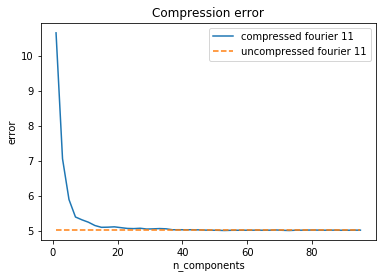

In [16]:
plot_compression_error(n_components, compressed, uncompressed, ["fourier 11"])

We can also compare the results to the theory. Since $M(x,y)u$ should be in the order of the mean wind speed, we would expect $|M(x,y)|^2$ to be approximately inversely proportional to the number of stations. We can then estimate the theoretical fomula above as follows:

pivoting data
computing pca components
fitting windfields


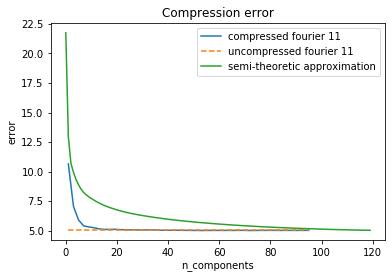

In [23]:
# Create a TimeCompression object
tc = TimeCompression(stations = data.station_id.unique(), n_components = 120, windfield_factory = factories[0])

# Fit tc to the data
tc.fit(data)

# Extract the eigen values from the pca analysis
eig_u = tc.pca_U.explained_variance_
eig_v = tc.pca_V.explained_variance_

# Define the partial sums of the eigenvalues 
# As derived in the theory
approx_error = np.array([ (sum(eig_u[i:]) + sum(eig_v[i:]))/120 + uncompressed[0]  for i in range(len(eig_u))])

plot_compression_error(n_components, compressed, uncompressed, ["fourier 11"])
plt.plot(approx_error, label = "semi-theoretic approximation")
plt.legend()

The theoretic approximation seems to be an upper bound, which is expected since we devised is as such. By the looks of it, it is on the side of being too conservative and doesn't really give us a good estimation.